# Installing packages and import libraries

In [1]:
!pip install imbalanced-learn
!pip install scikeras

In [2]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sb
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import  SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model

# Helper functions

In [3]:
# Function to plot the input features (histograms)
def plotWeatherInputFeaturesHist(df_weather):
  # Plotting the distribution among the weather features
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots

  # Plot data in each subplot
  axs[0, 0].hist(df_weather['rain_hour'], bins=20, color='b', alpha=0.7)
  axs[0, 0].set_title('rain_hour')

  axs[0, 1].hist(df_weather['temperature'], bins=20, color='b', alpha=0.7)
  axs[0, 1].set_title('temperature')

  axs[1, 0].hist(df_weather['pressure_relative'], bins=20, color='b', alpha=0.7)
  axs[1, 0].set_title('pressure_relative')

  axs[1, 1].hist(df_weather['wind_speed'], bins=20, color='b', alpha=0.7)
  axs[1, 1].set_title('wind_speed')

  plt.tight_layout()
  plt.savefig('input_feature_distribution.svg', format='svg')
  plt.show()

# Function to plot the input features (boxplots)
def plotWeatherInputFeaturesBox(df_weather):
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots

  # Plot data in each subplot
  axs[0, 0].boxplot(df_weather['rain_hour'])
  axs[0, 0].set_title('rain_hour')

  axs[0, 1].boxplot(df_weather['temperature'])
  axs[0, 1].set_title('temperature')

  axs[1, 0].boxplot(df_weather['pressure_relative'])
  axs[1, 0].set_title('pressure_relative')

  axs[1, 1].boxplot(df_weather['wind_speed'])
  axs[1, 1].set_title('wind_speed')

  plt.tight_layout()
  plt.savefig('input_feature_distribution_box.svg', format='svg')
  plt.show()

# Function to calculate distance between two coordinate points in km
def calcDistance(locationA, locationB):
  return geodesic(locationA, locationB).kilometers

# Evaluation functions
def printClassificationReport(y_real, y_pred, set):
  # Print the classification report
  print(f'Classification repport for {set} set: ')
  print(metrics.classification_report(y_real, y_pred))
  print()

def printConfusionMatrix(y_real, y_pred):
  # Visualize confusion matrix
  plt.figure()
  classes = ['Not overflow', 'Overflow']
  cf_matrix = confusion_matrix(y_real, y_pred)
  cm = sb.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, xticklabels=classes, yticklabels=classes)
  cm.set_xlabel('Predicted', fontsize=10)
  cm.set_ylabel('Actual', fontsize=10)
  cm.set_title('Confusion matrix')
  plt.savefig("confusion_matrix.svg", format='svg')
  plt.show()

# Functions to plot model loss and accuracy
def plot_model_loss(history):
  plt.figure(figsize=(15,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['Train','Val'], loc= 'upper left')
  plt.savefig("model_loss.svg", format='svg')
  plt.show()

def plot_model_accuracy(history):
  plt.figure(figsize=(15,6))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig("model_accuracy.svg", format='svg')
  plt.show()

# Data Preprocessing

## Import data

In [4]:
# Import from my drive and display the first 5 rows
path = ""
df_overflow = pd.read_csv(f'{path}overflow_export.csv')
df_weather = pd.read_csv(f'{path}weather_station_export.csv')

In [5]:
# View the overflow dataframe
df_overflow.head()

,bucket,overflow,warning,name,latitude,longitude
0,2020-10-26 11:00:00,1,1,21-1036-AA-00003,59.40472,10.48086
1,2020-10-26 12:00:00,1,1,21-1036-AA-00003,59.40472,10.48086
2,2020-10-26 12:00:00,0,0,21-1036-AA-00001,59.39825,10.47472
3,2020-10-26 12:00:00,0,1,21-1036-AA-00004,59.40752,10.48266
4,2020-10-26 13:00:00,0,1,21-1036-AA-00001,59.39825,10.47472


In [6]:
# Describe the overflow dataframe
df_overflow.describe()

,overflow,warning,latitude,longitude
count,656402.000000,656402.000000,654092.000000,654092.000000
mean,0.040236,0.083793,59.381028,10.455200
std,0.196512,0.277078,0.045284,0.045917
min,0.000000,0.000000,59.183500,10.238800
25%,0.000000,0.000000,59.357835,10.452063
50%,0.000000,0.000000,59.384226,10.464838
75%,0.000000,0.000000,59.410847,10.477847
max,1.000000,1.000000,59.432912,10.494273


In [7]:
# View the weather station dataframe
df_weather.head()

,bucket,rain_hour,temperature,pressure_relative,wind_speed,name,latitude,longitude
0,2020-11-11 16:00:00,0.000,7.15,1023,5.930,Horten Havn værstasjon,NaN,NaN
1,2020-11-11 16:00:00,0.155,6.96,1016,0.714,Nykirke værstasjon,59.427723,10.384876
2,2020-11-11 16:00:00,0.977,6.94,1023,5.750,Røråsen værstasjon,59.419871,10.464622
3,2020-11-11 16:00:00,0.223,7.03,1015,0.000,Skoppum værstasjon,59.384501,10.398446
4,2020-11-11 16:00:00,0.445,7.31,1023,1.500,Åsgårdstrand værstasjon,59.356279,10.459576


In [8]:
# Describe the weather dataframe
df_weather.describe()

,rain_hour,temperature,pressure_relative,wind_speed,latitude,longitude
count,140729.000000,140729.000000,140729.000000,140729.000000,112294.000000,112294.000000
mean,0.100020,7.168081,1009.841085,2.581646,59.397295,10.426554
std,0.514868,8.532777,12.311068,2.159618,0.028597,0.035613
min,0.000000,-24.800000,961.000000,0.000000,59.356279,10.384876
25%,0.000000,0.864000,1002.000000,0.958000,59.384501,10.384876
50%,0.000000,6.560000,1011.000000,2.090000,59.419871,10.398446
75%,0.000000,14.200000,1018.000000,3.680000,59.427723,10.459576
max,28.400000,36.300000,1042.000000,19.100000,59.427723,10.464622


## Check for and handle null values

In [9]:
# Check for null values
print(df_overflow.isnull().sum())
print('#-----------------------#')
print(df_weather.isnull().sum())

bucket          0
overflow        0
warning         0
name            0
latitude     2310
longitude    2310
dtype: int64
#-----------------------#
bucket                   0
rain_hour                0
temperature              0
pressure_relative        0
wind_speed               0
name                     0
latitude             28435
longitude            28435
dtype: int64


In [10]:
# Since the geo-location is missing, drop those columns
df_overflow.dropna(subset=['latitude','longitude'], inplace=True)
df_weather.dropna(subset=['latitude','longitude'], inplace=True)

## Time conversion

In [11]:
# Convert bucket column from epoch ms to datetime
df_weather['time'] = pd.to_datetime(df_weather['bucket'], unit='ns')
df_overflow['time'] = pd.to_datetime(df_overflow['bucket'], unit='ns')

# Convert from UTC to local time
df_overflow['time'] = df_overflow['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Oslo')
df_weather['time'] = df_weather['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Oslo')

In [12]:
# Drop the bucket columns
df_weather = df_weather.drop(axis='columns', columns='bucket')
df_overflow = df_overflow.drop(axis='columns', columns='bucket')

## Plot the feature distribution of weather data

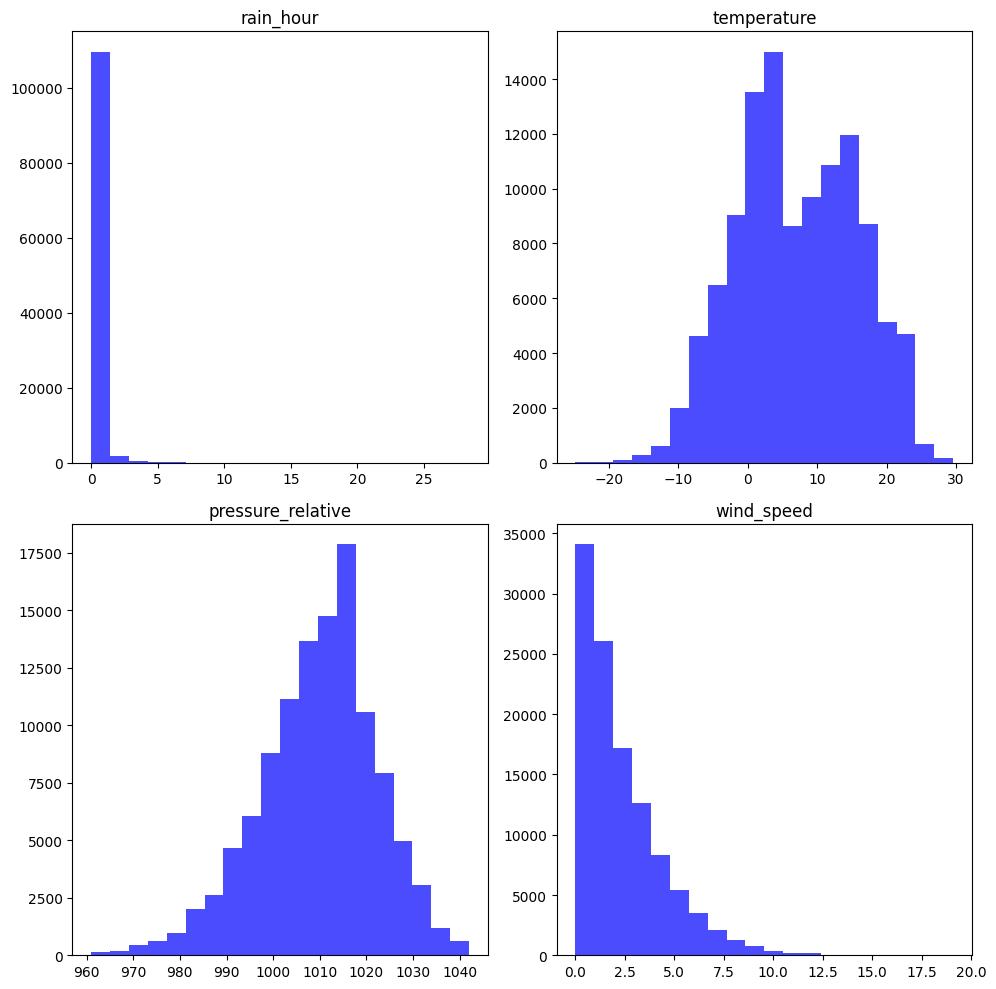

In [13]:
# Plot the initial distribution
plotWeatherInputFeaturesHist(df_weather)

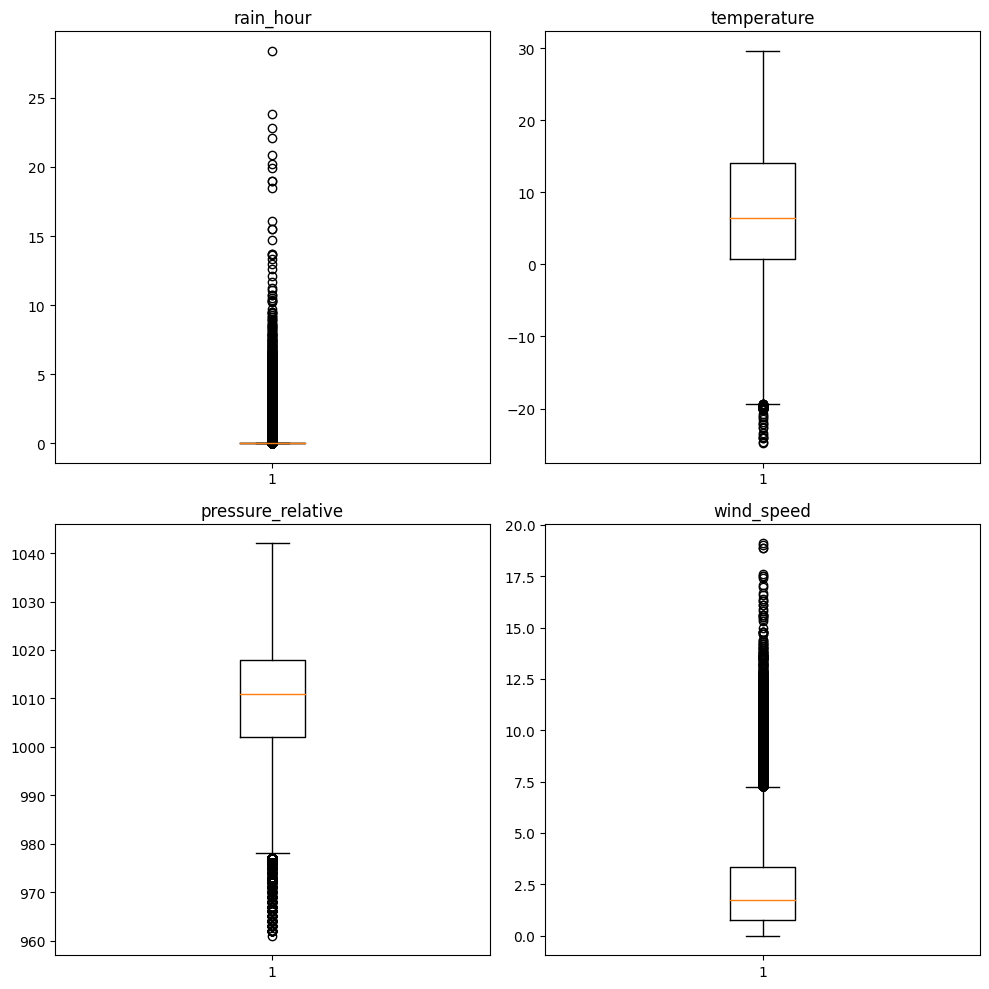

In [14]:
plotWeatherInputFeaturesBox(df_weather)

## Square root transformation on wind_speed

In [15]:
# Since wind speed looked left skewed, performing square root transformation
df_weather['wind_speed'] = np.sqrt(df_weather['wind_speed'])

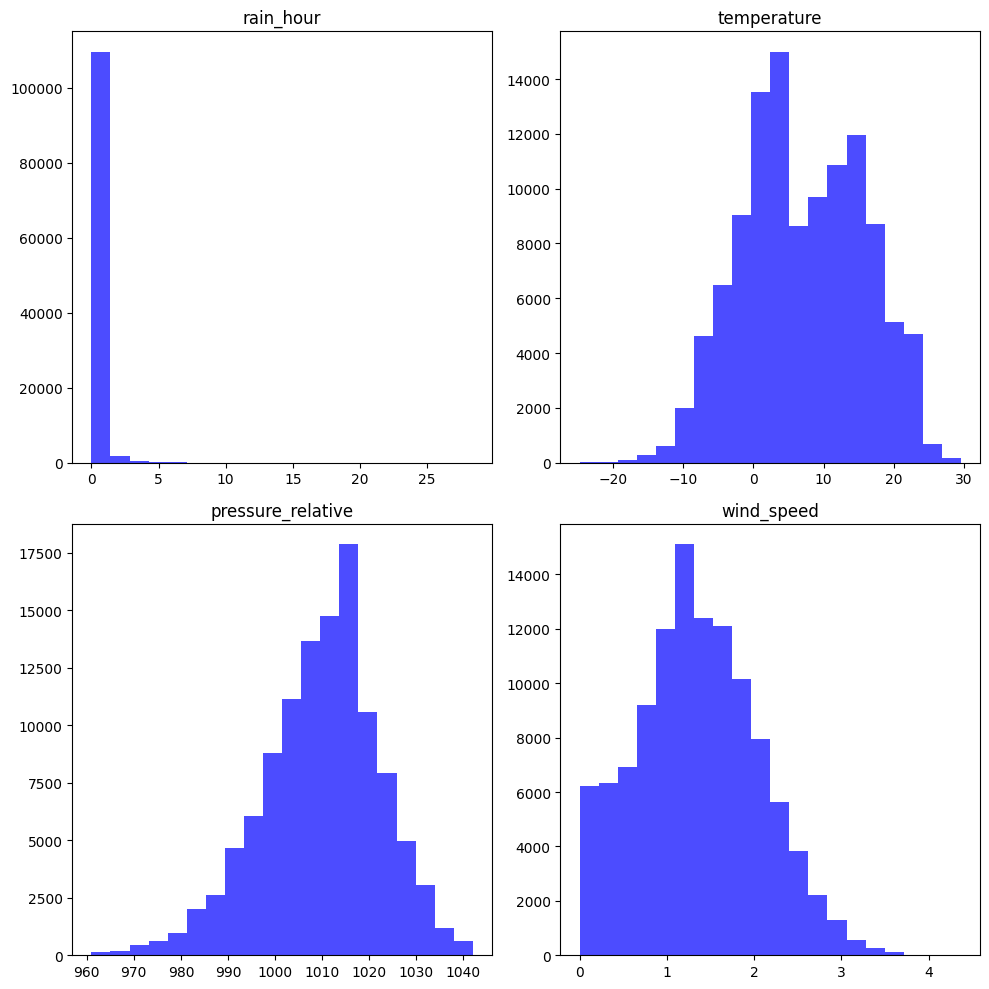

In [16]:
# Plot the distribution after square root transformation
plotWeatherInputFeaturesHist(df_weather)

## Merge dataframes on time

In [17]:
# Merge dataframes on time
df_merged = pd.merge(df_overflow,df_weather, how='inner', on='time')
df_merged = df_merged.rename(columns={"name_x": "sensor_name", "name_y": "weather_station_name", "latitude_x":"sensor_latitude","longitude_x":"sensor_longitude","latitude_y":"weather_station_latitude","longitude_y":"weather_station_longitude"})

## Match sensor to closest weather station

In [18]:
# Selecting unique sensor names along with their locations
unique_sensors = df_merged[['sensor_name', 'sensor_latitude', 'sensor_longitude']].drop_duplicates()

# Selecting unique weather station names along with their locations
unique_weather_stations = df_merged[['weather_station_name', 'weather_station_latitude', 'weather_station_longitude']].drop_duplicates()

# Delete the rows where the weather station "NetatmoNykirkeKlokkeråsen"
# Delete due to bad data quality, (sensor has stored data while being indoors, under roof, burried in snow etc)
unique_weather_stations = unique_weather_stations.drop(unique_weather_stations[unique_weather_stations['weather_station_name'] == 'NetatmoNykirkeKlokkeråsen'].index)

In [19]:
# Find the closest weather station for each sensor

# Mappings of sensor to closest weather station
sensor_to_station = {} # sensor_name to weather_station_name
sensor_distances = {} # distance to closest weather station

# Loop through the rows using iterrows()
for index_x, row_x in unique_sensors.iterrows():
  min_distance = 1000
  min_distance_station = ""

  for index_y, row_y in unique_weather_stations.iterrows():
    # Calculate the distance
    distance = calcDistance((row_x['sensor_latitude'], row_x['sensor_longitude']), (row_y['weather_station_latitude'],row_y['weather_station_longitude']))

    # If distance is less than min, update distance
    if distance < min_distance:
      min_distance = distance
      min_distance_station = unique_weather_stations.loc[index_y].at['weather_station_name']

  # Add sensor to weather station mapping
  sensor_to_station[row_x["sensor_name"]] = min_distance_station
  sensor_distances[row_x["sensor_name"]] = min_distance

print(sensor_to_station)

{'21-1036-AA-00001': 'Røråsen værstasjon', '21-1036-AA-00003': 'Røråsen værstasjon', '21-1036-AA-00004': 'Røråsen værstasjon', '21-1036-AA-00011': 'Åsgårdstrand værstasjon', '21-1036-AA-00006': 'Røråsen værstasjon', '21-1036-AA-00002': 'Røråsen værstasjon', '21-1036-AA-00005': 'Røråsen værstasjon', '21-1036-AA-00008': 'Åsgårdstrand værstasjon', '21-1036-AA-00007': 'Åsgårdstrand værstasjon', '21-1036-AA-00009': 'Åsgårdstrand værstasjon', '21-1036-AA-00010': 'Røråsen værstasjon', '21-1036-AA-00020': 'Åsgårdstrand værstasjon', '21-1036-AA-00013': 'Røråsen værstasjon', '21-1036-AA-00018': 'Åsgårdstrand værstasjon', '21-1036-AA-00019': 'Åsgårdstrand værstasjon', '21-1036-AA-00021': 'Skoppum værstasjon', '21-1036-AA-00025': 'Åsgårdstrand værstasjon', '21-1036-AA-00044': 'Åsgårdstrand værstasjon', '21-1036-AA-00048': 'Skoppum værstasjon', '21-1036-AA-00017': 'Røråsen værstasjon', '21-1036-AA-00037': 'Røråsen værstasjon', '21-1036-AA-00041': 'Åsgårdstrand værstasjon', '21-1036-AA-00039': 'Åsgå

In [20]:
# Delete the rows where the weather station "NetatmoNykirkeKlokkeråsen"
# Delete due to bad data quality
df_merged = df_merged.drop(df_merged[df_merged['weather_station_name'] == 'NetatmoNykirkeKlokkeråsen'].index)

In [21]:
# Filter DataFrame based on given sensor to station mapping
filtered_df = df_merged[df_merged['weather_station_name'] == df_merged['sensor_name'].map(sensor_to_station)]

# Add a distance to weather station column
filtered_df = filtered_df.copy()
filtered_df['distance_to_weather_station'] = filtered_df['sensor_name'].map(sensor_distances)

# Remove weather station location columns
df = filtered_df.drop(columns=['weather_station_latitude','weather_station_longitude'],axis='columns')
df.head()

,overflow,warning,sensor_name,sensor_latitude,sensor_longitude,time,rain_hour,temperature,pressure_relative,wind_speed,weather_station_name,distance_to_weather_station
1,0,0,21-1036-AA-00001,59.39825,10.47472,2020-11-11 17:00:00+01:00,0.977,6.94,1023,2.397916,Røråsen værstasjon,2.475958
5,0,1,21-1036-AA-00003,59.40472,10.48086,2020-11-11 17:00:00+01:00,0.977,6.94,1023,2.397916,Røråsen værstasjon,1.923312
9,0,1,21-1036-AA-00003,59.40472,10.48086,2020-11-11 18:00:00+01:00,0.642,6.91,1022,2.135416,Røråsen værstasjon,1.923312
13,0,0,21-1036-AA-00001,59.39825,10.47472,2020-11-11 18:00:00+01:00,0.642,6.91,1022,2.135416,Røråsen værstasjon,2.475958
17,0,0,21-1036-AA-00001,59.39825,10.47472,2020-11-11 19:00:00+01:00,0.335,6.70,1022,2.525866,Røråsen værstasjon,2.475958


## Binning

In [22]:
# Try to balance the rain_hour feature
bins = [0, 0.1, 1, 10, df['rain_hour'].max()]
labels = [0,1,2,3]
df['rain_hour_binned'] = pd.cut(df['rain_hour'], bins=bins, labels=labels)
print(df.rain_hour_binned.value_counts())

# Repace null values for rain_hour_binned with category 0
df['rain_hour_binned'] = df['rain_hour_binned'].fillna(0)

# Ensure the rain_hour_binned is int and not categorical
df['rain_hour_binned'] = df['rain_hour_binned'].astype(int)
df.dtypes

1    45585
0    22308
2    22194
3      158
Name: rain_hour_binned, dtype: int64


overflow                                             int64
warning                                              int64
sensor_name                                         object
sensor_latitude                                    float64
sensor_longitude                                   float64
time                           datetime64[ns, Europe/Oslo]
rain_hour                                          float64
temperature                                        float64
pressure_relative                                    int64
wind_speed                                         float64
weather_station_name                                object
distance_to_weather_station                        float64
rain_hour_binned                                     int64
dtype: object

## Feature engineering


In [23]:
# Create columns month and day of week
df['month'] = pd.DatetimeIndex(df['time']).month
df['hour'] = pd.DatetimeIndex(df['time']).hour
df['day_of_week'] = pd.DatetimeIndex(df['time']).dayofweek

In [24]:
# Use time as index
df = df.set_index('time')
df.sort_values(by='time',inplace=True)
df.head()

,overflow,warning,sensor_name,sensor_latitude,sensor_longitude,rain_hour,temperature,pressure_relative,wind_speed,weather_station_name,distance_to_weather_station,rain_hour_binned,month,hour,day_of_week
time,,,,,,,,,,,,,,,
2020-11-11 17:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.977,6.94,1023,2.397916,Røråsen værstasjon,2.475958,1,11,17,2
2020-11-11 17:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.977,6.94,1023,2.397916,Røråsen værstasjon,1.923312,1,11,17,2
2020-11-11 18:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.642,6.91,1022,2.135416,Røråsen værstasjon,1.923312,1,11,18,2
2020-11-11 18:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.642,6.91,1022,2.135416,Røråsen værstasjon,2.475958,1,11,18,2
2020-11-11 19:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.335,6.70,1022,2.525866,Røråsen værstasjon,2.475958,1,11,19,2


In [25]:
# Create features
# Rainfall trends
df['rainfall_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['rainfall_rate_change_1week'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=168)

# Temperature trends
df['temperature_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['temperature_rate_change_1week'] = df.groupby(['sensor_name'])['temperature'].diff(periods=168)

# Relative pressure trends
df['pressure_relative_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['pressure_relative_rate_change_1week'] = df.groupby(['sensor_name'])['pressure_relative'].diff(periods=168)

# Wind speed trends
df['wind_speed_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['wind_speed_rate_change_1week'] = df.groupby(['sensor_name'])['wind_speed'].diff(periods=168)

# Rainfall Intensity Peaks
df['rainfall_intensity_peak'] = df['rain_hour'].rolling(window=24, center=True).max()  # Find local maxima

# Extreme Rainfall Events
threshold = df['rain_hour'].quantile(0.95)  # Threshold for extreme events set to 95 quantile
df['extreme_rain_event'] = np.where(df['rain_hour'] > threshold, 1, 0)  # Binary indicator for extreme events

# Rain hour above average (true/false)
rain_hour_mean = df['rain_hour'].mean()
df['rain_hour_above_mean'] = np.where(df['rain_hour'] > rain_hour_mean, 1, 0)

# Rain hour above average (amount)
df['rain_hour_amount_above_mean'] = df['rain_hour'] - rain_hour_mean

# Remove nulls
df = df.fillna(0)
df.head()

,overflow,warning,sensor_name,sensor_latitude,sensor_longitude,rain_hour,temperature,pressure_relative,wind_speed,weather_station_name,...,temperature_rate_change_1month,temperature_rate_change_1week,pressure_relative_rate_change_1month,pressure_relative_rate_change_1week,wind_speed_rate_change_1month,wind_speed_rate_change_1week,rainfall_intensity_peak,extreme_rain_event,rain_hour_above_mean,rain_hour_amount_above_mean
time,,,,,,,,,,,,,,,,,,,,,
2020-11-11 17:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.977,6.94,1023,2.397916,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.856104
2020-11-11 17:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.977,6.94,1023,2.397916,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.856104
2020-11-11 18:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.642,6.91,1022,2.135416,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.521104
2020-11-11 18:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.642,6.91,1022,2.135416,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.521104
2020-11-11 19:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.335,6.70,1022,2.525866,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.214104


## Adding Gausian noise

In [26]:
# Generate Gaussian noise for the continious columns, except location and distance
selected_columns = ['rain_hour', 'temperature', 'wind_speed']
mu, sigma = 0, 0.1  # Adjust as needed
noise = np.random.normal(mu, sigma, size=(len(df), len(selected_columns)))

# Add noise to the selected columns
df[selected_columns] += noise

# Clip the rain and wind speed values to be non-negative
df['rain_hour'] = df['rain_hour'].clip(lower=0)
df['wind_speed'] = df['wind_speed'].clip(lower=0)

## Visualize the data

### Plot timeseries

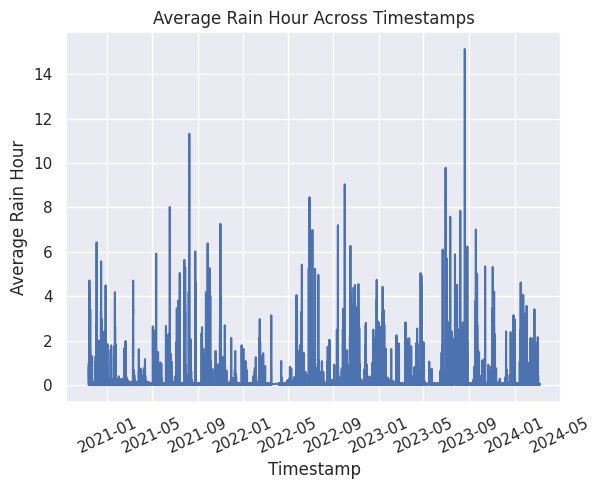

In [27]:
# Calculate the average rain_hour per timestamp
average_rain_hour = df.groupby('time')['rain_hour'].mean().reset_index()

# create the time series plot
sb.set(font_scale=1)
sb.lineplot(x = "time", y = "rain_hour",
             data = average_rain_hour)

plt.xticks(rotation = 25)

# Customize the plot (add labels, title, etc.)
plt.xlabel('Timestamp')
plt.ylabel('Average Rain Hour')
plt.title('Average Rain Hour Across Timestamps')

# Show the plot
plt.show()

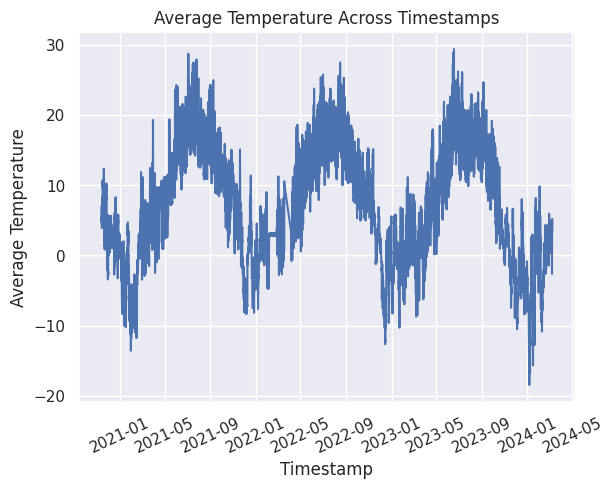

In [28]:
# Calculate the average temperature per timestamp
average_temperature = df.groupby('time')['temperature'].mean().reset_index()

# create the time series plot
sb.lineplot(x = "time", y = "temperature",
             data = average_temperature)

plt.xticks(rotation = 25)

# Customize the plot (add labels, title, etc.)
plt.xlabel('Timestamp')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Across Timestamps')

# Show the plot
plt.show()

### Plot distribution of target variable

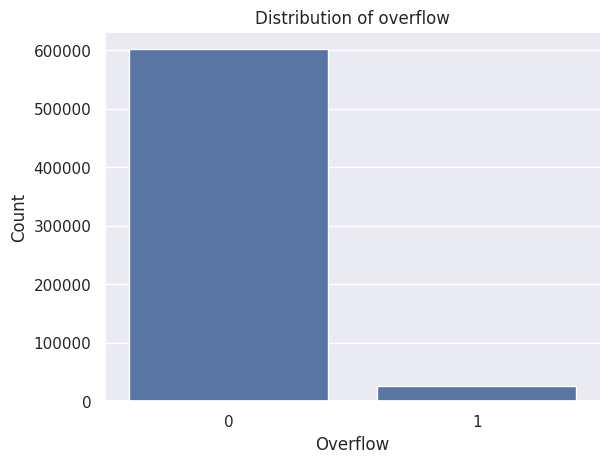

In [29]:
# Check the distribution of overflow (count of 0 and 1)
sb.countplot(data=df, x="overflow")

# Customize the plot (add labels, title, etc.)
plt.xlabel('Overflow')
plt.ylabel('Count')
plt.title('Distribution of overflow')

# Show the plot
plt.savefig("target_variable_distribution.svg", format='svg')
plt.show()

## Feature selection

### Plot correlation matrix

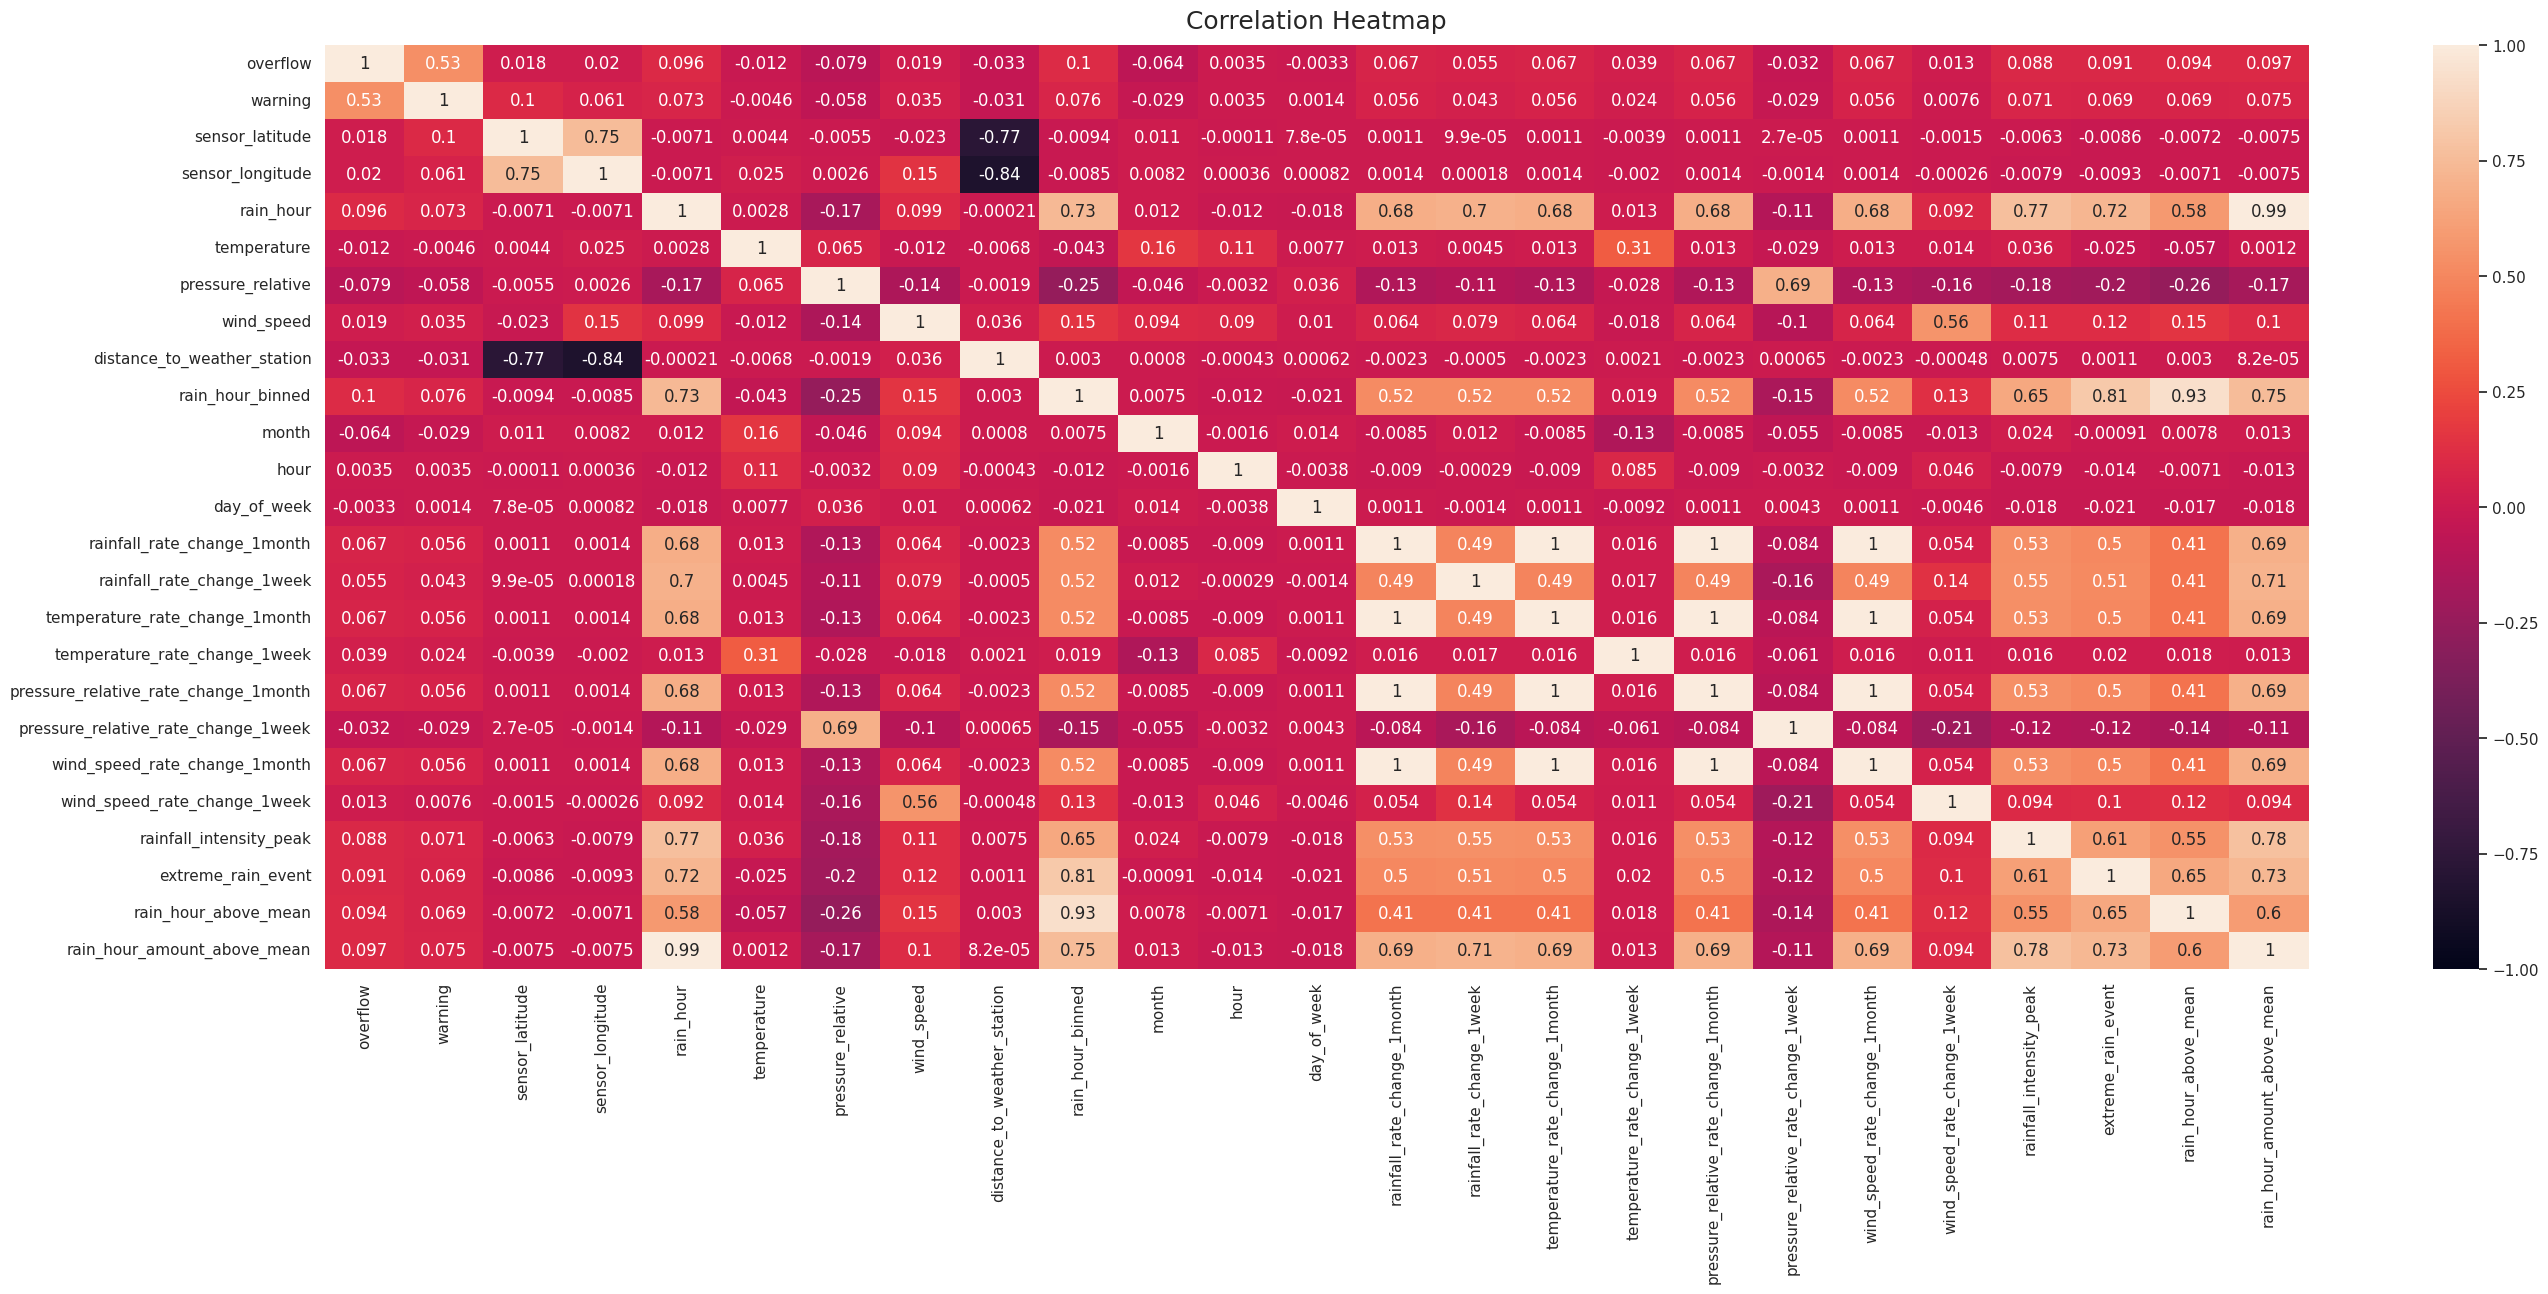

In [30]:
# Calculate the correlation matrix
corr = df.corr(numeric_only=True)

# Increase the size of the heatmap.
plt.figure(figsize=(32, 12))

# Plot the heatmap
sb.set(font_scale=1)
heatmap = sb.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig("correlation_matrix.svg", format='svg')

### Select features

In [31]:
# Pick the 10 columns with highest correlation to target
# Do not include warning, as this does not give the prediction we want
# Include the target column as well, it will be split later
columns = ['overflow',
           'rain_hour_binned',
           'rain_hour',
           'rain_hour_amount_above_mean',
           'extreme_rain_event',
           'rainfall_intensity_peak',
           'pressure_relative',
           'rain_hour_above_mean',
           'rainfall_rate_change_1month',
           'temperature_rate_change_1month',
           'pressure_relative_rate_change_1month']
df = df[columns]

In [32]:
df.head()

,overflow,rain_hour_binned,rain_hour,rain_hour_amount_above_mean,extreme_rain_event,rainfall_intensity_peak,pressure_relative,rain_hour_above_mean,rainfall_rate_change_1month,temperature_rate_change_1month,pressure_relative_rate_change_1month
time,,,,,,,,,,,
2020-11-11 17:00:00+01:00,0,1,1.108279,0.856104,1,0.0,1023,1,0.0,0.0,0.0
2020-11-11 17:00:00+01:00,0,1,0.827694,0.856104,1,0.0,1023,1,0.0,0.0,0.0
2020-11-11 18:00:00+01:00,0,1,0.831649,0.521104,0,0.0,1022,1,0.0,0.0,0.0
2020-11-11 18:00:00+01:00,0,1,0.807891,0.521104,0,0.0,1022,1,0.0,0.0,0.0
2020-11-11 19:00:00+01:00,0,1,0.270489,0.214104,0,0.0,1022,1,0.0,0.0,0.0


## Split into features and target variable

In [33]:
# Make copy of dataframe
ml_df = df.copy(deep=True)

# Split into test, training and validation
X = ml_df.drop(columns=['overflow'], axis='columns')
y = ml_df['overflow']

## Split data into train, test and validation sets

In [34]:
# Split into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Resample the data

In [35]:
# Use SMOTE for sampling
resample = SMOTE(sampling_strategy='minority', k_neighbors=10)
print('Before SMOTE: ')
print(y_train.value_counts())
X_train, y_train = resample.fit_resample(X_train, y_train)
print('After SMOTE: ')
print(y_train.value_counts())

Before SMOTE: 
0    90206
1     3851
Name: overflow, dtype: int64
After SMOTE: 
0    90206
1    90206
Name: overflow, dtype: int64


## Normalize the data

In [36]:
# Perform normalization
norm = RobustScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)
X_val = norm.transform(X_val)

## Impute data

In [37]:
# Use constant imputation for filling missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
X_val = imputer.transform(X_val)

# Model development


## Logistic regression

### Hyperparameter tuning

In [ ]:
# Build the model with defaults
ml_model_tuning = LogisticRegression()

In [ ]:
# Use grid search to find the best parameters for LogisticRegression()
C = [0.25, 0.5, 0.75, 1]
solver = ['saga']
random_state = [16, 32, 48]
max_iter = [100, 200, 300, 400]
parameters = {'solver':solver, 'C':C, 'max_iter':max_iter, 'random_state':random_state}
grid = GridSearchCV(ml_model_tuning, parameters, scoring=['f1','accuracy'], refit='f1')
grid_results = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_f1']
stds = grid_results.cv_results_['std_test_f1']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.556259 using {'C': 1, 'max_iter': 100, 'random_state': 48, 'solver': 'saga'}
0.556246 (0.003677) with: {'C': 0.25, 'max_iter': 100, 'random_state': 16, 'solver': 'saga'}
0.556241 (0.003693) with: {'C': 0.25, 'max_iter': 100, 'random_state': 32, 'solver': 'saga'}
0.556237 (0.003687) with: {'C': 0.25, 'max_iter': 100, 'random_state': 48, 'solver': 'saga'}
0.555467 (0.003881) with: {'C': 0.25, 'max_iter': 200, 'random_state': 16, 'solver': 'saga'}
0.555467 (0.003881) with: {'C': 0.25, 'max_iter': 200, 'random_state': 32, 'solver': 'saga'}
0.555458 (0.003884) with: {'C': 0.25, 'max_iter': 200, 'random_state': 48, 'solver': 'saga'}
0.555214 (0.003811) with: {'C': 0.25, 'max_iter': 300, 'random_state': 16, 'solver': 'saga'}
0.555205 (0.003795) with: {'C': 0.25, 'max_iter': 300, 'random_state': 32, 'solver': 'saga'}
0.555214 (0.003811) with: {'C': 0.25, 'max_iter': 300, 'random_state': 48, 'solver': 'saga'}
0.555132 (0.003765) with: {'C': 0.25, 'max_iter': 400, 'random_state': 16, 'so

### Build and train the model

In [38]:
# Train the model
ml_model = LogisticRegression(max_iter=100, solver='saga', C=1, random_state=48)
ml_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, random_state=48, solver='saga')

### Predict

In [39]:
# Predict
y_pred_train = ml_model.predict(X_train)
y_pred_test = ml_model.predict(X_test)

### Evaluate

Classification repport for test set: 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83    481222
           1       0.07      0.47      0.12     20419

    accuracy                           0.72    501641
   macro avg       0.52      0.60      0.48    501641
weighted avg       0.93      0.72      0.80    501641




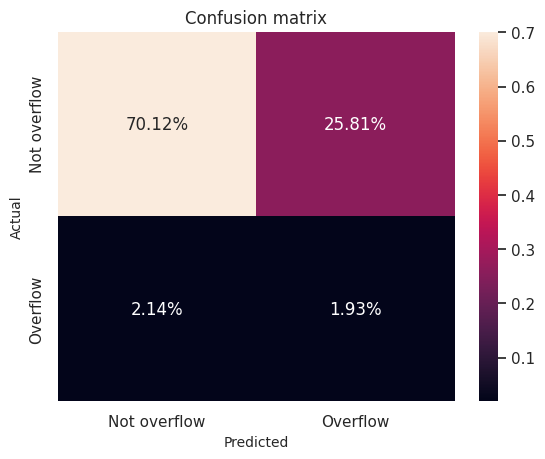

In [40]:
# Print classification report and confusion matrix
printClassificationReport(y_test,y_pred_test, 'test')
printConfusionMatrix(y_test, y_pred_test)

## LSTM


In [ ]:
# Reshape input data
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
# Function to define the model
def create_model(optimizer: str, activation: str, numFeatures: int):
  model = Sequential()
  model.add(Dense(units=numFeatures,input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation=activation))
  model.add(LSTM(units=128, activation=activation, return_sequences=True))
  model.add(LSTM(dropout=0.5,units=64, activation=activation, return_sequences=True))
  model.add(LSTM(units=32, activation=activation))
  model.add(Dense(units=1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### Hyperparameter tuning

In [ ]:
# Create KerasClassifier for our model using adam as optimizer
dl_model_classifier_adam = KerasClassifier(model=create_model('adam', 'tanh', len(X.columns)), verbose=0)

In [ ]:
# Define the grid search parameters
batch_size = [10, 15, 25, 50]
epochs = [2]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform the grid search
grid = GridSearchCV(estimator=dl_model_classifier_adam, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')
grid_result = grid.fit(X_train_reshaped, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Summarize results from the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.606844 using {'batch_size': 15, 'epochs': 2}
0.600038 (0.003933) with: {'batch_size': 10, 'epochs': 2}
0.606844 (0.001729) with: {'batch_size': 15, 'epochs': 2}
0.603574 (0.003387) with: {'batch_size': 25, 'epochs': 2}
0.605897 (0.000574) with: {'batch_size': 50, 'epochs': 2}


### Build and train the model

In [ ]:
# Create the model
dl_model = create_model('SGD', 'tanh', len(X.columns))

# Will stop the training when there is no improvement in
# the validation accuracy for 10 consecutive epochs.
es = EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)

In [ ]:
# Train the model
history_dl = dl_model.fit(X_train_reshaped,
                    y_train,
                    callbacks=[es],
                    epochs=20,
                    batch_size=15,
                    validation_data=(X_val_reshaped,y_val),
                    shuffle=True)

Epoch 1/20
12028/12028 [==============================] - 135s 10ms/step - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6919 - val_accuracy: 0.7805
Epoch 2/20
12028/12028 [==============================] - 102s 8ms/step - loss: 0.6919 - accuracy: 0.5424 - val_loss: 0.6887 - val_accuracy: 0.7795
Epoch 3/20
12028/12028 [==============================] - 105s 9ms/step - loss: 0.6879 - accuracy: 0.5851 - val_loss: 0.6816 - val_accuracy: 0.7221
Epoch 4/20
12028/12028 [==============================] - 107s 9ms/step - loss: 0.6720 - accuracy: 0.5977 - val_loss: 0.6398 - val_accuracy: 0.7417
Epoch 5/20
12028/12028 [==============================] - 116s 10ms/step - loss: 0.6624 - accuracy: 0.5986 - val_loss: 0.6616 - val_accuracy: 0.7277
Epoch 6/20
12028/12028 [==============================] - 103s 9ms/step - loss: 0.6593 - accuracy: 0.6010 - val_loss: 0.6361 - val_accuracy: 0.7644
Epoch 7/20
12028/12028 [==============================] - 102s 8ms/step - loss: 0.6584 - accuracy: 0.6020 - va

### Predict

In [ ]:
# Make predictions
predictions = dl_model.predict(X_test_reshaped)

15677/15677 [==============================] - 58s 4ms/step


### Evaluate

Classification repport for test set: 
              precision    recall  f1-score   support

           0       0.97      0.79      0.87    481222
           1       0.08      0.42      0.13     20419

    accuracy                           0.77    501641
   macro avg       0.52      0.60      0.50    501641
weighted avg       0.93      0.77      0.84    501641




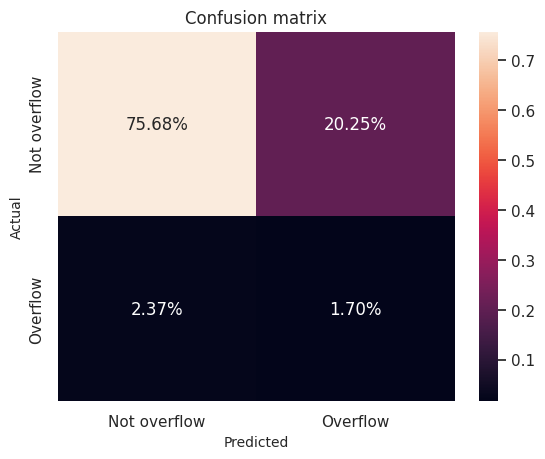

In [ ]:
# Print classification report and confusion matrix
printClassificationReport(y_test,predictions.round(), 'test')
printConfusionMatrix(y_test, predictions.round())

In [ ]:
# Probability of each class in the test set
# The model should at least do as well as this
print(f'Not overflow (0): {y_test.value_counts()[0]/len(y_test)}')
print(f'Overflow (1): {y_test.value_counts()[1]/len(y_test)}')

Not overflow (0): 0.9592955918674909
Overflow (1): 0.040704408132509105


In [ ]:
# Evaluate the model on the test data using `evaluate`
score = dl_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'Loss: {score[0]}  Accuracy: {score[1]}') #dl_model.metrics_names gives the labels

Loss: 0.6693077087402344  Accuracy: 0.8841900825500488


### Visualising the training loss and accuracies


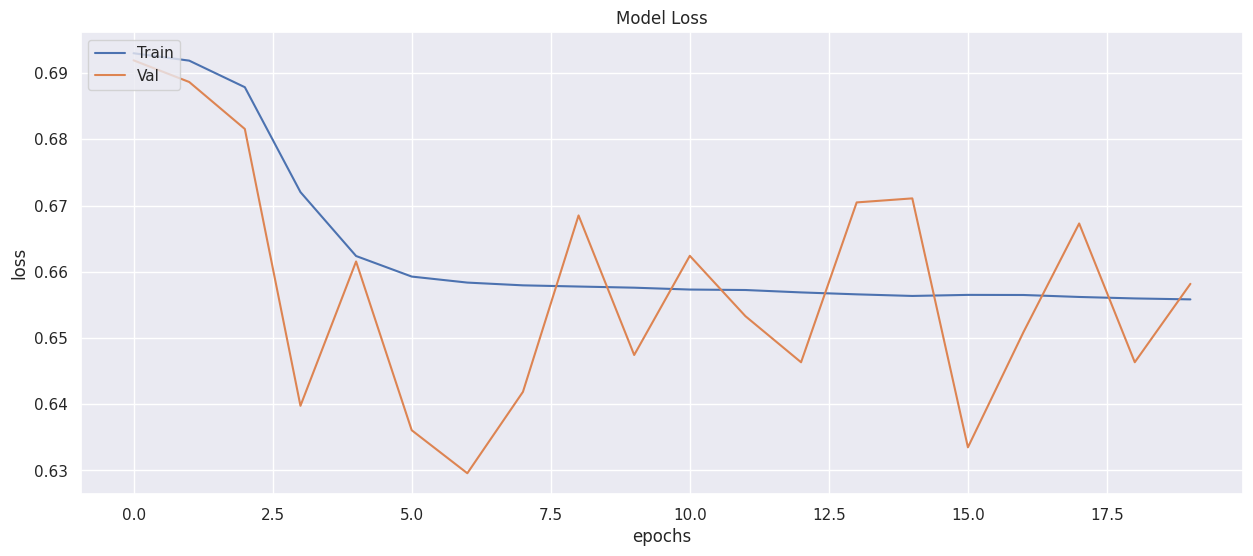

In [ ]:
plot_model_loss(history_dl)

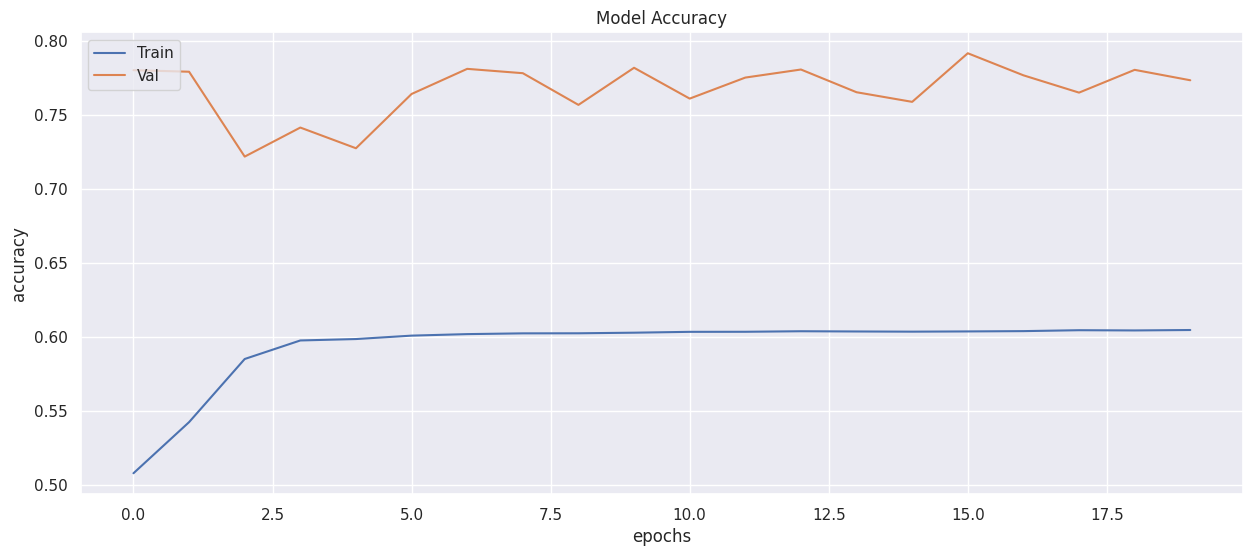

In [ ]:
plot_model_accuracy(history_dl)

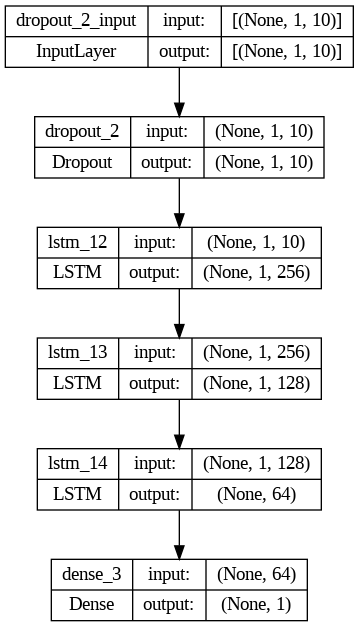

In [ ]:
# Ploting the model
plot_model(dl_model, to_file='model.png', show_shapes=True)